### Calculate and plot the seasonal climatology of Southern Ocean chlorophyll-a from MODIS

In [66]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Some thoughts
13.01.22  
- To get climatological average, I will need to interpolate onto the same days. DONE

#### Load data
Preprocessing step required to assign date index to each dataset

In [51]:
rootdir = '/local/data/modis/L3m_8D_chl_a_9km/'
filenames = 'A*.nc'
def preprocess(ds):
    time = pd.to_datetime(ds.attrs['time_coverage_start'])
    return ds.expand_dims({'time':[time]})
ds = xr.open_mfdataset(rootdir+filenames,preprocess=preprocess,use_cftime=False)
ds['time'] = pd.to_datetime(ds['time'].values)

#### Averaging and processing
- Take spatial average
- Interpolate onto each day of the year (necessary for taking temporal average)
- NOTE: presently extrapolating at start and end of year, where no data. Exception is for 2002 when half of the year is not covered. Could also keep these unfilled but might cause some issues in averaging. E.g. Extrapolation also looks problematic for **2021**.

In [151]:
# Extract spatial average for each year
# Interpolate to each of 365 days
years = np.arange(2002,2022)
days = np.arange(1,366)
ds_year = xr.DataArray(dims=['day','year'],coords={'year':years,'day':days})
for i,year in enumerate(years):
    print(year)
    chl = ds['chlor_a'].mean(['lat','lon']).sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')})
    if year==2002:
        fill_value=np.nan
    else:
        fill_value=np.nan
    chl_allyear = chl.assign_coords({'time':chl['time.dayofyear']}).interp({'time':days},kwargs={'fill_value': fill_value})
    ds_year.loc[{'year':year}]=chl_allyear.values

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


#### Plot

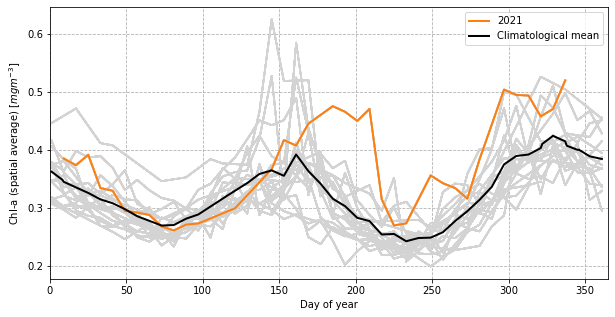

In [152]:
fig,ax = plt.subplots(figsize=(10,5))
# All years
for year in years[:-1]:
    ax.plot(ds_year['day'],ds_year,color='lightgray')
# 2021
ax.plot(ds_year['day'],ds_year.isel(year=-1),color='tab:orange',linewidth=2,label='2021')
# Climatology
ds_clim = ds_year.mean('year')
ax.plot(ds_year['day'],ds_clim,color='black',linewidth=2,label='Climatological mean')

ax.set_xlim(0,365)
ax.set_xlabel('Day of year')
ax.set_ylabel('Chl-a (spatial average) [$mgm^{-3}$]')
ax.grid(linestyle='--')

ax.legend()